## Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
!pip install pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from pathlib import Path
%matplotlib inline
!pip install Google-Colab-Transfer
import colab_transfer
colab_transfer.mount_google_drive()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive/


## Prepare Training Data and the Nature of the Data

You can obtain your shot dataset and read it here by changing the given path.
You can see the first 5 lines of the dataset and properties of features.

In [2]:
project_dir = "/content/drive/MyDrive/xG Project/"

In [3]:
dataset = pd.read_csv(project_dir+"shoot_dataset.csv")

In [4]:
dataset.head()

,Situation,LastAction,X-Coordinate,Y-Coordinate,ShotType,Result,xG
0,OpenPlay,Aerial,0.876,0.602,Head,BlockedShot,0.019479
1,OpenPlay,Cross,0.878,0.430,Head,MissedShots,0.031428
2,OpenPlay,Pass,0.858,0.679,StrongFoot,MissedShots,0.060696
3,OpenPlay,TakeOn,0.831,0.655,StrongFoot,MissedShots,0.127710
4,FromCorner,Cross,0.943,0.500,Head,MissedShots,0.445354


You can see the meanings and properties of features below.


**Situation:** It shows the origin of the position. 

The possible values for this features are "OpenPlay", "FromCorner", "SetPiece", "Penalty", "DirectFreekick". 

Here "SetPiece" refers to any organization after a free kick and "DirectFreekick" refers to freekicks that are directly aimed to the goal.

**LastAction:** It shows the last action taken before the shot.

The possible values for this features are "Aerial", "Cross", "Pass", "TakeOn", "Chipped", "SetPiece", "BallTouch", "BallRecovery", "None", "HeadPass", "LayOff", "Rebound", "Throughball".

**X-Coordinate:** It shows the normalized x coordinate of the place in the pitch where shot is taken. Let say there is a shot of Team A against Team B. It takes 0 if the shot is taken from exactly the goal line of Team B and it takes 1 if the shot is taken from exactly the goal line of Team A.

**Y-Coordinate:** It shows the normalized y coordinate of the place in the pitch where shot is taken. Let say there is a shot of Team A against Team B. It takes 0 if the shot is taken from exactly the touchline that is at the left of the goal of Team B and it takes 1 if the shot is taken from the touchline that is at the right of the goal of Team B. Trivially, penalties have exactly y=0.5.

**ShotType:** It shows the type of the shot according to stronger foot of the footballer.

The possible values for this features are "Head", "StrongFoot", "WeakFoot", "OtherBodyPart".

**Result:** It shows the result of the shot. Note that I just used it for label information, whether the shot results in a goal or not. It is not included in training data since it is highly correlated to prediction and I think including it as a feature is not in line with the philosophy of xG.

The possible values for this features are "BlockedShot", "MissedShots", "Goal", "SavedShot", "ShotOnPost".

**xG:** It is the xG value of the shot calculated by the authors of the dataset. I used it for comparison.

In [5]:
categorical_features = ["Situation", "LastAction", "ShotType", "Result"]

for feature in categorical_features:
  print(f"The possible values for the feature {feature} : {dataset[feature].unique()}")

The possible values for the feature Situation : ['OpenPlay' 'FromCorner' 'SetPiece' 'Penalty' 'DirectFreekick']
The possible values for the feature LastAction : ['Aerial' 'Cross' 'Pass' 'TakeOn' 'Chipped' 'SetPiece' 'BallTouch'
 'BallRecovery' 'None' 'HeadPass' 'LayOff' 'Rebound' 'Throughball']
The possible values for the feature ShotType : ['Head' 'StrongFoot' 'WeakFoot' 'OtherBodyPart']
The possible values for the feature Result : ['BlockedShot' 'MissedShots' 'Goal' 'SavedShot' 'ShotOnPost']


In [6]:
y = np.array([1 if result == 'Goal' else 0 for result in dataset['Result']])
xG_values = dataset['xG']

I dropped the features xG and Result. Then, I splitted the training set into training, validation and test sets.

In [7]:
train = dataset.copy()
train = train.drop('xG', axis=1)
train = train.drop('Result', axis=1)

In [8]:
train.head()

,Situation,LastAction,X-Coordinate,Y-Coordinate,ShotType
0,OpenPlay,Aerial,0.876,0.602,Head
1,OpenPlay,Cross,0.878,0.430,Head
2,OpenPlay,Pass,0.858,0.679,StrongFoot
3,OpenPlay,TakeOn,0.831,0.655,StrongFoot
4,FromCorner,Cross,0.943,0.500,Head


In [9]:
dataset_length = len(train)

train_val_indices, test_indices = train_test_split(range(dataset_length), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(train_val_indices, test_size= 0.2/0.6, random_state=0)

## TabNet Application

First of all, the following code snippet is highly inspired from TabNet's official GitHub page. Also, you can see the reference and link to TabNet's GitHub page in case you want to take a look at.

Reference: S. Ö. Arik και T. Pfister, ‘TabNet: Attentive Interpretable Tabular Learning’, CoRR, τ. abs/1908.07442, 2019.

Official GitHub Page: https://github.com/dreamquark-ai/tabnet

To start, I encoded the categorical features in the following way suggested by TabNet.

In [10]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    l_enc = LabelEncoder()
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

In [11]:
features = [ col for col in train.columns] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [12]:
categorical_columns

['Situation', 'LastAction', 'ShotType']

In [13]:
cat_idxs

[0, 1, 4]

In [14]:
categorical_dims

{'LastAction': 13, 'ShotType': 4, 'Situation': 5}

In [15]:
cat_dims

[5, 13, 4]

Initialize the TabNetClassifier here. You can change the parameters related to the model. You can look at the documentation (link is below) for detailed information about parameters. If you have no access to any device with cuda, you can just delete that line. Also, you can set verbose parameter to $x$, if you want to get log for each $x$ epochs.

Then, I will run the fit function to train the model. You can also look at its parameters from the documentation.

Documentation Link: https://dreamquark-ai.github.io/tabnet/generated_docs/README.html

In [ ]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15,
    device_name="cuda",
    verbose=5,
)

Device used : cuda


In [16]:
X_train = train[features].values[train_indices]
y_train = y[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = y[valid_indices]

X_test = train[features].values[test_indices]
y_test = y[test_indices]

In [ ]:
max_epochs = 200

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=70,
    batch_size=16384, virtual_batch_size=256,
) 

epoch 0  | loss: 0.79305 | train_auc: 0.53862 | valid_auc: 0.54303 |  0:00:05s
epoch 5  | loss: 0.27728 | train_auc: 0.52911 | valid_auc: 0.5266  |  0:00:39s
epoch 10 | loss: 0.27551 | train_auc: 0.61379 | valid_auc: 0.61696 |  0:01:11s
epoch 15 | loss: 0.27182 | train_auc: 0.63929 | valid_auc: 0.64171 |  0:01:40s
epoch 20 | loss: 0.27216 | train_auc: 0.65477 | valid_auc: 0.65289 |  0:02:09s
epoch 25 | loss: 0.27099 | train_auc: 0.69254 | valid_auc: 0.68993 |  0:02:39s
epoch 30 | loss: 0.27096 | train_auc: 0.71042 | valid_auc: 0.70689 |  0:03:09s
epoch 35 | loss: 0.27002 | train_auc: 0.7367  | valid_auc: 0.73309 |  0:03:38s
epoch 40 | loss: 0.27018 | train_auc: 0.76703 | valid_auc: 0.76316 |  0:04:08s
epoch 45 | loss: 0.2702  | train_auc: 0.78645 | valid_auc: 0.78149 |  0:04:37s
epoch 50 | loss: 0.26877 | train_auc: 0.79849 | valid_auc: 0.79367 |  0:05:07s
epoch 55 | loss: 0.26939 | train_auc: 0.80646 | valid_auc: 0.80193 |  0:05:37s
epoch 60 | loss: 0.26813 | train_auc: 0.80888 | vali

## Evaluation

For evaluation, I will take the probability values for being a goal and I will compare it with baseline by using Mean Absolute Error. I will also use classical metrics such as accuracy, precision, etc.

In [ ]:
predictions = clf.predict_proba(X_test)
preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
y_pred = np.vectorize(preds_mapper.get)(np.argmax(predictions, axis=1)) #y_pred only contains 0 or 1

xG_predictions = predictions[:,1] #x_G contains values between 0 and 1

In [ ]:
y_test_xG = xG_values.values[test_indices]
MAE = abs(xG_predictions-y_test_xG).mean()
print(f"MAE according to the baseline is : {MAE}")

MAE according to the baseline is : 0.04556515139028101


In [ ]:
conf_matrix = confusion_matrix(y_pred=y_pred, y_true=y_test)

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"Test Set Accuracy is : {test_acc}")

test_prec = precision_score(y_pred=y_pred, y_true=y_test)
print(f"Test Set Precision is : {test_prec}")

test_recall = recall_score(y_pred=y_pred, y_true=y_test)
print(f"Test Set Recall is : {test_recall}")

test_roc_auc = roc_auc_score(y_test,y_pred)
print(f"Test Set Area Under ROC is : {test_roc_auc}")

test_fp_rate = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
print(f"Test Set False Positive Rate is : {test_fp_rate}")

test_specificity = conf_matrix[0][0]/(conf_matrix[0][0]+conf_matrix[0][1])
print(f"Test Set Specificity is : {test_specificity}")

Test Set Accuracy is : 0.9037702159804966
Test Set Precision is : 0.6552532833020638
Test Set Recall is : 0.22291367480453167
Test Set Area Under ROC is : 0.6043866744518436
Test Set False Positive Rate is : 0.014140325900844571
Test Set Specificity is : 0.9858596740991554


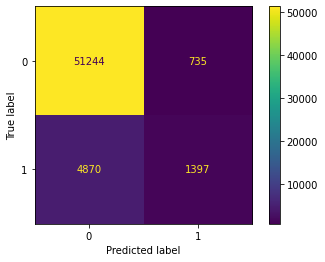

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
plt.show()

The model rarely predicts a goal, but the goal is rare in the football. Indeed nearly 9% of the shots become goal, the model predicts nearly 3% of shots as goal. When it predicts the result as a goal nearly one of the three predictions are wrong. I thought that the reason can be about football, so I looked at the given xG values as predictions and calculated confusion matrix, too. The reason may be choosing the probability 0.5 as the boundary.

In [ ]:
y_pred_xG = [1 if xG>=0.5 else 0 for xG in xG_values[test_indices]]

In [ ]:
conf_matrix = confusion_matrix(y_pred=y_pred_xG, y_true=y_test)

test_acc = accuracy_score(y_pred=y_pred_xG, y_true=y_test)
print(f"Test Set Accuracy is : {test_acc}")

test_prec = precision_score(y_pred=y_pred_xG, y_true=y_test)
print(f"Test Set Precision is : {test_prec}")

test_recall = recall_score(y_pred=y_pred_xG, y_true=y_test)
print(f"Test Set Recall is : {test_recall}")

test_roc_auc = roc_auc_score(y_test,y_pred_xG)
print(f"Test Set Area Under ROC is : {test_roc_auc}")

test_fp_rate = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
print(f"Test Set False Positive Rate is : {test_fp_rate}")

test_specificity = conf_matrix[0][0]/(conf_matrix[0][0]+conf_matrix[0][1])
print(f"Test Set Specificity is : {test_specificity}")

Test Set Accuracy is : 0.9073069395323284
Test Set Precision is : 0.6454423592493298
Test Set Recall is : 0.30732407850646243
Test Set Area Under ROC is : 0.6434848523123512
Test Set False Positive Rate is : 0.02035437388175994
Test Set Specificity is : 0.97964562611824


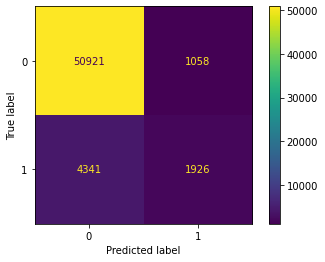

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
plt.show()

The performance of baseline model and our model is similar. Therefore, I think our model is successful for football domain, but it is open to improvements. I am planning to do hyperparameter tuning and also I am planning to use same model on a different shot dataset to see the success of the model.

## Explainability

In [ ]:
for i in range(len(features)):
  print(f"Importance of {features[i]} is {clf.feature_importances_[i]}")

Importance of Situation is 0.13356820583139814
Importance of LastAction is 0.2440353677030107
Importance of X-Coordinate is 0.2181789690040219
Importance of Y-Coordinate is 0.24868782676003923
Importance of ShotType is 0.15552963070153003


## Save and Load

In [ ]:
saved_path = clf.save_model(project_dir+"xG_TabNet")

Successfully saved model at /content/drive/MyDrive/xG Project/xG_TabNet.zip


In [ ]:
loaded_clf = TabNetClassifier()
loaded_clf.load_model(project_dir+"xG_TabNet.zip")

Device used : cuda
Device used : cuda


In [ ]:
loaded_preds = loaded_clf.predict_proba(X_test)

In [ ]:
eps = 1e-4
if np.any(abs(predictions-loaded_preds)>eps):
  print("The model may be loaded in a false way, or the error is just about floating points")
else:
  print("The model is correctly loaded")

The model is correctly loaded


## Hyperparameter Tuning

The following code hypertunes the parameter for TabNet Classifier. Since I am new to use package "hyperopt", it can be improved. Note that hyperparameter tuning uses lots of resources. Since I have limited resources, I did a mini version of hyperparameter tuning here to show how one can do it, but max_evals number can (must) be increased to obtain a better result. Also, authors suggested that n_d should be equal to n_a. Therefore, I only tuned one of them.

"space" shows the parameters to be tuned, "objective" is the objective funtion to minimize. I tuned them according to accuracy score, but I am planning to do it with other metrics such as recall and precision.

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

max_epochs = 100

def objective(params):
  clf = TabNetClassifier(
      n_d = params["n_d"],
      n_a = params["n_d"],
      n_steps = params["n_steps"],
      gamma = params["gamma"],
      n_independent = params["n_independent"], 
      n_shared = params["n_shared"],
      momentum = params["momentum"],
      clip_value = params["clip_value"],
      lambda_sparse = params["lambda_sparse"],
      optimizer_fn = torch.optim.Adam, optimizer_params = dict(lr=2e-2), 
      scheduler_fn = torch.optim.lr_scheduler.StepLR, 
      scheduler_params = {'gamma' : 0.95, 'step_size': 100},
      device_name = "cuda",
      verbose = 5
      )

  clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=70,
    batch_size=16384, virtual_batch_size=256,
    )
  predictions = clf.predict_proba(X_test)
  preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
  y_pred = np.vectorize(preds_mapper.get)(np.argmax(predictions, axis=1))
  return {'loss': -accuracy_score(y_test, y_pred), 'status': STATUS_OK}

space = {
  'n_d': hp.choice('n_d', [8,16,32,64]),
  'n_steps': hp.choice('n_steps', range(3,11)),
  'gamma': hp.quniform('gamma', 1., 2., 0.1),
  'n_independent': hp.choice('n_independent', range(1,6)),
  'n_shared': hp.choice('n_shared', range(1,6)),
  'momentum': hp.uniform('momentum ', 0.01, 0.4),
  'clip_value': hp.uniform('clip_value ', 1., 10.),
  'lambda_sparse': hp.uniform('lambda_sparse', 1e-5, 1e-2)
  } #space of hyperparameters that we are tuning

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

Device used : cuda
epoch 0  | loss: 0.44746 | train_auc: 0.48989 | valid_auc: 0.49084 |  0:00:12s
epoch 5  | loss: 0.28067 | train_auc: 0.57838 | valid_auc: 0.57606 |  0:01:16s
epoch 10 | loss: 0.27828 | train_auc: 0.63785 | valid_auc: 0.63536 |  0:02:19s
epoch 15 | loss: 0.276   | train_auc: 0.64422 | valid_auc: 0.64322 |  0:03:24s
epoch 20 | loss: 0.27506 | train_auc: 0.66346 | valid_auc: 0.66185 |  0:04:27s
epoch 25 | loss: 0.27517 | train_auc: 0.68609 | valid_auc: 0.68332 |  0:05:30s
epoch 30 | loss: 0.27435 | train_auc: 0.71444 | valid_auc: 0.71148 |  0:06:32s
epoch 35 | loss: 0.27406 | train_auc: 0.74471 | valid_auc: 0.74191 |  0:07:34s
epoch 40 | loss: 0.2741  | train_auc: 0.76566 | valid_auc: 0.76223 |  0:08:37s
epoch 45 | loss: 0.27394 | train_auc: 0.78445 | valid_auc: 0.78213 |  0:09:40s
epoch 50 | loss: 0.27328 | train_auc: 0.7986  | valid_auc: 0.79506 |  0:10:42s
epoch 55 | loss: 0.273   | train_auc: 0.80673 | valid_auc: 0.80199 |  0:11:45s
epoch 60 | loss: 0.27254 | train_

In [ ]:
parameters = space_eval(space, best)

print(f"Best Parameters : {parameters}")

Best Parameters : {'clip_value': 9.432673774482696, 'gamma': 1.7000000000000002, 'lambda_sparse': 0.0062646815230475925, 'momentum': 0.24715634334910527, 'n_d': 16, 'n_independent': 4, 'n_shared': 1, 'n_steps': 4}


In [ ]:
max_epochs = 200

clf = TabNetClassifier(
      n_d = parameters["n_d"],
      n_a = parameters["n_d"],
      n_steps = parameters["n_steps"],
      gamma = parameters["gamma"],
      n_independent = parameters["n_independent"], 
      n_shared = parameters["n_shared"],
      momentum = parameters["momentum"],
      clip_value = parameters["clip_value"],
      lambda_sparse = parameters["lambda_sparse"],
      optimizer_fn = torch.optim.Adam, optimizer_params = dict(lr=2e-2), 
      scheduler_fn = torch.optim.lr_scheduler.StepLR, 
      scheduler_params = {'gamma' : 0.95, 'step_size': 100},
      device_name = "cuda",
      verbose = 5
      )

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=70,
    batch_size=16384, virtual_batch_size=256,
    )

Device used : cuda
epoch 0  | loss: 0.90254 | train_auc: 0.55285 | valid_auc: 0.55704 |  0:00:06s
epoch 5  | loss: 0.28041 | train_auc: 0.58374 | valid_auc: 0.5849  |  0:00:36s
epoch 10 | loss: 0.27643 | train_auc: 0.5798  | valid_auc: 0.57885 |  0:01:09s
epoch 15 | loss: 0.27388 | train_auc: 0.61579 | valid_auc: 0.61445 |  0:01:39s
epoch 20 | loss: 0.27309 | train_auc: 0.65486 | valid_auc: 0.6522  |  0:02:08s
epoch 25 | loss: 0.27238 | train_auc: 0.69727 | valid_auc: 0.69359 |  0:02:36s
epoch 30 | loss: 0.27205 | train_auc: 0.73447 | valid_auc: 0.73165 |  0:03:05s
epoch 35 | loss: 0.2713  | train_auc: 0.74832 | valid_auc: 0.74411 |  0:03:33s
epoch 40 | loss: 0.27089 | train_auc: 0.77821 | valid_auc: 0.77335 |  0:04:02s
epoch 45 | loss: 0.27001 | train_auc: 0.78952 | valid_auc: 0.7852  |  0:04:31s
epoch 50 | loss: 0.27015 | train_auc: 0.79805 | valid_auc: 0.79409 |  0:04:59s
epoch 55 | loss: 0.26942 | train_auc: 0.80262 | valid_auc: 0.79857 |  0:05:28s
epoch 60 | loss: 0.26972 | train_

In [ ]:
predictions = clf.predict_proba(X_test)
preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
y_pred = np.vectorize(preds_mapper.get)(np.argmax(predictions, axis=1)) #y_pred only contains 0 or 1

xG_predictions = predictions[:,1] #x_G contains values between 0 and 1

In [ ]:
y_test_xG = xG_values.values[test_indices]
MAE = abs(xG_predictions-y_test_xG).mean()
print(f"MAE according to the baseline is : {MAE}")

MAE according to the baseline is : 0.04337650707291204


In [ ]:
conf_matrix = confusion_matrix(y_pred=y_pred, y_true=y_test)

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"Test Set Accuracy is : {test_acc}")

test_prec = precision_score(y_pred=y_pred, y_true=y_test)
print(f"Test Set Precision is : {test_prec}")

test_recall = recall_score(y_pred=y_pred, y_true=y_test)
print(f"Test Set Recall is : {test_recall}")

test_roc_auc = roc_auc_score(y_test,y_pred)
print(f"Test Set Area Under ROC is : {test_roc_auc}")

test_fp_rate = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
print(f"Test Set False Positive Rate is : {test_fp_rate}")

test_specificity = conf_matrix[0][0]/(conf_matrix[0][0]+conf_matrix[0][1])
print(f"Test Set Specificity is : {test_specificity}")

Test Set Accuracy is : 0.9038732273460839
Test Set Precision is : 0.6948658109684948
Test Set Recall is : 0.19004308281474389
Test Set Area Under ROC is : 0.5899906635528538
Test Set False Positive Rate is : 0.010061755709036342
Test Set Specificity is : 0.9899382442909637


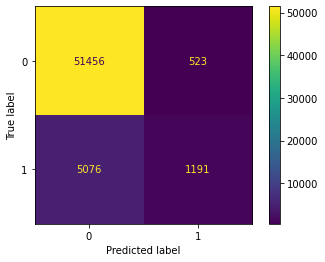

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
plt.show()

The results are not much improved. I will try it with precision and recall scores.

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

max_epochs = 100

def objective(params):
  clf = TabNetClassifier(
      n_d = params["n_d"],
      n_a = params["n_d"],
      n_steps = params["n_steps"],
      gamma = params["gamma"],
      n_independent = params["n_independent"], 
      n_shared = params["n_shared"],
      momentum = params["momentum"],
      clip_value = params["clip_value"],
      lambda_sparse = params["lambda_sparse"],
      optimizer_fn = torch.optim.Adam, optimizer_params = dict(lr=2e-2), 
      scheduler_fn = torch.optim.lr_scheduler.StepLR, 
      scheduler_params = {'gamma' : 0.95, 'step_size': 100},
      device_name = "cuda",
      verbose = 5
      )

  clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=70,
    batch_size=16384, virtual_batch_size=256,
    )
  predictions = clf.predict_proba(X_test)
  preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
  y_pred = np.vectorize(preds_mapper.get)(np.argmax(predictions, axis=1))
  return {'loss': -precision_score(y_test, y_pred), 'status': STATUS_OK}

space = {
  'n_d': hp.choice('n_d', [8,16,32,64]),
  'n_steps': hp.choice('n_steps', range(3,11)),
  'gamma': hp.quniform('gamma', 1., 2., 0.1),
  'n_independent': hp.choice('n_independent', range(1,6)),
  'n_shared': hp.choice('n_shared', range(1,6)),
  'momentum': hp.uniform('momentum ', 0.01, 0.4),
  'clip_value': hp.uniform('clip_value ', 1., 10.),
  'lambda_sparse': hp.uniform('lambda_sparse', 1e-5, 1e-2)
  } #space of hyperparameters that we are tuning

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

Device used : cuda
epoch 0  | loss: 0.39563 | train_auc: 0.40441 | valid_auc: 0.40673 |  0:00:05s
epoch 5  | loss: 0.27525 | train_auc: 0.52575 | valid_auc: 0.52498 |  0:00:33s
epoch 10 | loss: 0.2718  | train_auc: 0.61142 | valid_auc: 0.6121  |  0:01:01s
epoch 15 | loss: 0.26998 | train_auc: 0.64023 | valid_auc: 0.63947 |  0:01:30s
epoch 20 | loss: 0.27004 | train_auc: 0.66805 | valid_auc: 0.66599 |  0:01:58s
epoch 25 | loss: 0.2699  | train_auc: 0.69452 | valid_auc: 0.69176 |  0:02:25s
epoch 30 | loss: 0.26946 | train_auc: 0.72716 | valid_auc: 0.72417 |  0:02:53s
epoch 35 | loss: 0.26902 | train_auc: 0.74942 | valid_auc: 0.74546 |  0:03:21s
epoch 40 | loss: 0.2692  | train_auc: 0.77091 | valid_auc: 0.76742 |  0:03:49s
epoch 45 | loss: 0.26928 | train_auc: 0.79161 | valid_auc: 0.78702 |  0:04:18s
epoch 50 | loss: 0.26881 | train_auc: 0.80305 | valid_auc: 0.79819 |  0:04:46s
epoch 55 | loss: 0.26886 | train_auc: 0.80429 | valid_auc: 0.79874 |  0:05:14s
epoch 60 | loss: 0.26865 | train_

In [ ]:
parameters = space_eval(space, best)

print(f"Best Parameters : {parameters}")

Best Parameters : {'clip_value': 1.8527282511745433, 'gamma': 1.9000000000000001, 'lambda_sparse': 0.003597124290957617, 'momentum': 0.26737350533263066, 'n_d': 32, 'n_independent': 4, 'n_shared': 4, 'n_steps': 9}


In [ ]:
max_epochs = 200

clf = TabNetClassifier(
      n_d = parameters["n_d"],
      n_a = parameters["n_d"],
      n_steps = parameters["n_steps"],
      gamma = parameters["gamma"],
      n_independent = parameters["n_independent"], 
      n_shared = parameters["n_shared"],
      momentum = parameters["momentum"],
      clip_value = parameters["clip_value"],
      lambda_sparse = parameters["lambda_sparse"],
      optimizer_fn = torch.optim.Adam, optimizer_params = dict(lr=2e-2), 
      scheduler_fn = torch.optim.lr_scheduler.StepLR, 
      scheduler_params = {'gamma' : 0.95, 'step_size': 100},
      device_name = "cuda",
      verbose = 5
      )

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=70,
    batch_size=16384, virtual_batch_size=256,
    )

Device used : cuda
epoch 0  | loss: 0.56357 | train_auc: 0.51031 | valid_auc: 0.50776 |  0:00:12s
epoch 5  | loss: 0.28849 | train_auc: 0.53576 | valid_auc: 0.53458 |  0:01:17s
epoch 10 | loss: 0.28098 | train_auc: 0.58427 | valid_auc: 0.57654 |  0:02:23s
epoch 15 | loss: 0.27722 | train_auc: 0.63479 | valid_auc: 0.63373 |  0:03:28s
epoch 20 | loss: 0.27752 | train_auc: 0.67494 | valid_auc: 0.67109 |  0:04:33s
epoch 25 | loss: 0.27572 | train_auc: 0.70485 | valid_auc: 0.70251 |  0:05:38s
epoch 30 | loss: 0.27538 | train_auc: 0.72633 | valid_auc: 0.72417 |  0:06:44s
epoch 35 | loss: 0.27334 | train_auc: 0.75188 | valid_auc: 0.75017 |  0:07:49s
epoch 40 | loss: 0.27555 | train_auc: 0.77912 | valid_auc: 0.77651 |  0:08:54s
epoch 45 | loss: 0.27935 | train_auc: 0.7731  | valid_auc: 0.77243 |  0:09:59s
epoch 50 | loss: 0.27529 | train_auc: 0.79252 | valid_auc: 0.79155 |  0:11:04s
epoch 55 | loss: 0.27262 | train_auc: 0.80047 | valid_auc: 0.79844 |  0:12:10s
epoch 60 | loss: 0.27307 | train_

In [ ]:
predictions = clf.predict_proba(X_test)
preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
y_pred = np.vectorize(preds_mapper.get)(np.argmax(predictions, axis=1)) #y_pred only contains 0 or 1

xG_predictions = predictions[:,1] #x_G contains values between 0 and 1

In [ ]:
y_test_xG = xG_values.values[test_indices]
MAE = abs(xG_predictions-y_test_xG).mean()
print(f"MAE according to the baseline is : {MAE}")

MAE according to the baseline is : 0.05322660908871031


In [ ]:
conf_matrix = confusion_matrix(y_pred=y_pred, y_true=y_test)

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"Test Set Accuracy is : {test_acc}")

test_prec = precision_score(y_pred=y_pred, y_true=y_test)
print(f"Test Set Precision is : {test_prec}")

test_recall = recall_score(y_pred=y_pred, y_true=y_test)
print(f"Test Set Recall is : {test_recall}")

test_roc_auc = roc_auc_score(y_test,y_pred)
print(f"Test Set Area Under ROC is : {test_roc_auc}")

test_fp_rate = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
print(f"Test Set False Positive Rate is : {test_fp_rate}")

test_specificity = conf_matrix[0][0]/(conf_matrix[0][0]+conf_matrix[0][1])
print(f"Test Set Specificity is : {test_specificity}")

Test Set Accuracy is : 0.8999416268928339
Test Set Precision is : 0.7719950433705081
Test Set Recall is : 0.09940960587202809
Test Set Area Under ROC is : 0.5479348573810784
Test Set False Positive Rate is : 0.0035398911098712942
Test Set Specificity is : 0.9964601088901287


In [17]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

max_epochs = 100

def objective(params):
  clf = TabNetClassifier(
      n_d = params["n_d"],
      n_a = params["n_d"],
      n_steps = params["n_steps"],
      gamma = params["gamma"],
      n_independent = params["n_independent"], 
      n_shared = params["n_shared"],
      momentum = params["momentum"],
      clip_value = params["clip_value"],
      lambda_sparse = params["lambda_sparse"],
      optimizer_fn = torch.optim.Adam, optimizer_params = dict(lr=2e-2), 
      scheduler_fn = torch.optim.lr_scheduler.StepLR, 
      scheduler_params = {'gamma' : 0.95, 'step_size': 100},
      device_name = "cuda",
      verbose = 5
      )

  clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=70,
    batch_size=16384, virtual_batch_size=256,
    )
  predictions = clf.predict_proba(X_test)
  preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
  y_pred = np.vectorize(preds_mapper.get)(np.argmax(predictions, axis=1))
  return {'loss': -recall_score(y_test, y_pred), 'status': STATUS_OK}

space = {
  'n_d': hp.choice('n_d', [8,16,32,64]),
  'n_steps': hp.choice('n_steps', range(3,11)),
  'gamma': hp.quniform('gamma', 1., 2., 0.1),
  'n_independent': hp.choice('n_independent', range(1,6)),
  'n_shared': hp.choice('n_shared', range(1,6)),
  'momentum': hp.uniform('momentum ', 0.01, 0.4),
  'clip_value': hp.uniform('clip_value ', 1., 10.),
  'lambda_sparse': hp.uniform('lambda_sparse', 1e-5, 1e-2)
  } #space of hyperparameters that we are tuning

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

Device used : cuda
epoch 0  | loss: 0.47145 | train_auc: 0.43508 | valid_auc: 0.43252 |  0:00:05s
epoch 5  | loss: 0.28529 | train_auc: 0.50358 | valid_auc: 0.50841 |  0:00:28s
epoch 10 | loss: 0.27977 | train_auc: 0.62498 | valid_auc: 0.62577 |  0:00:52s
epoch 15 | loss: 0.27548 | train_auc: 0.65826 | valid_auc: 0.65712 |  0:01:14s
epoch 20 | loss: 0.27364 | train_auc: 0.66683 | valid_auc: 0.66452 |  0:01:38s
epoch 25 | loss: 0.27264 | train_auc: 0.71319 | valid_auc: 0.71093 |  0:02:01s
epoch 30 | loss: 0.27248 | train_auc: 0.71532 | valid_auc: 0.71239 |  0:02:24s
epoch 35 | loss: 0.27228 | train_auc: 0.73005 | valid_auc: 0.72722 |  0:02:47s
epoch 40 | loss: 0.27146 | train_auc: 0.77633 | valid_auc: 0.77402 |  0:03:11s
epoch 45 | loss: 0.27075 | train_auc: 0.78908 | valid_auc: 0.7867  |  0:03:35s
epoch 50 | loss: 0.27065 | train_auc: 0.79465 | valid_auc: 0.79222 |  0:03:58s
epoch 55 | loss: 0.27054 | train_auc: 0.805   | valid_auc: 0.8019  |  0:04:21s
epoch 60 | loss: 0.27012 | train_

In [18]:
parameters = space_eval(space, best)

print(f"Best Parameters : {parameters}")

Best Parameters : {'clip_value': 2.004246412700432, 'gamma': 1.9000000000000001, 'lambda_sparse': 0.00395555294559826, 'momentum': 0.21624999693816632, 'n_d': 32, 'n_independent': 2, 'n_shared': 2, 'n_steps': 7}


In [19]:
max_epochs = 200

clf = TabNetClassifier(
      n_d = parameters["n_d"],
      n_a = parameters["n_d"],
      n_steps = parameters["n_steps"],
      gamma = parameters["gamma"],
      n_independent = parameters["n_independent"], 
      n_shared = parameters["n_shared"],
      momentum = parameters["momentum"],
      clip_value = parameters["clip_value"],
      lambda_sparse = parameters["lambda_sparse"],
      optimizer_fn = torch.optim.Adam, optimizer_params = dict(lr=2e-2), 
      scheduler_fn = torch.optim.lr_scheduler.StepLR, 
      scheduler_params = {'gamma' : 0.95, 'step_size': 100},
      device_name = "cuda",
      verbose = 5
      )

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=70,
    batch_size=16384, virtual_batch_size=256,
    )

Device used : cuda
epoch 0  | loss: 0.74826 | train_auc: 0.51871 | valid_auc: 0.52249 |  0:00:06s
epoch 5  | loss: 0.27973 | train_auc: 0.55524 | valid_auc: 0.54956 |  0:00:39s
epoch 10 | loss: 0.27596 | train_auc: 0.55788 | valid_auc: 0.55531 |  0:01:13s
epoch 15 | loss: 0.27909 | train_auc: 0.6226  | valid_auc: 0.62162 |  0:01:46s
epoch 20 | loss: 0.27705 | train_auc: 0.64028 | valid_auc: 0.63913 |  0:02:19s
epoch 25 | loss: 0.27703 | train_auc: 0.66946 | valid_auc: 0.6716  |  0:02:52s
epoch 30 | loss: 0.2755  | train_auc: 0.70742 | valid_auc: 0.70615 |  0:03:26s
epoch 35 | loss: 0.27576 | train_auc: 0.71602 | valid_auc: 0.71179 |  0:03:59s
epoch 40 | loss: 0.27415 | train_auc: 0.76759 | valid_auc: 0.76267 |  0:04:32s
epoch 45 | loss: 0.27519 | train_auc: 0.776   | valid_auc: 0.77252 |  0:05:05s
epoch 50 | loss: 0.27349 | train_auc: 0.78672 | valid_auc: 0.78294 |  0:05:38s
epoch 55 | loss: 0.27309 | train_auc: 0.795   | valid_auc: 0.78995 |  0:06:12s
epoch 60 | loss: 0.27241 | train_

In [20]:
predictions = clf.predict_proba(X_test)
preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
y_pred = np.vectorize(preds_mapper.get)(np.argmax(predictions, axis=1)) #y_pred only contains 0 or 1

xG_predictions = predictions[:,1] #x_G contains values between 0 and 1

In [21]:
y_test_xG = xG_values.values[test_indices]
MAE = abs(xG_predictions-y_test_xG).mean()
print(f"MAE according to the baseline is : {MAE}")

MAE according to the baseline is : 0.04570388513351045


In [22]:
conf_matrix = confusion_matrix(y_pred=y_pred, y_true=y_test)

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"Test Set Accuracy is : {test_acc}")

test_prec = precision_score(y_pred=y_pred, y_true=y_test)
print(f"Test Set Precision is : {test_prec}")

test_recall = recall_score(y_pred=y_pred, y_true=y_test)
print(f"Test Set Recall is : {test_recall}")

test_roc_auc = roc_auc_score(y_test,y_pred)
print(f"Test Set Area Under ROC is : {test_roc_auc}")

test_fp_rate = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
print(f"Test Set False Positive Rate is : {test_fp_rate}")

test_specificity = conf_matrix[0][0]/(conf_matrix[0][0]+conf_matrix[0][1])
print(f"Test Set Specificity is : {test_specificity}")

Test Set Accuracy is : 0.9032723277134911
Test Set Precision is : 0.6708041014570966
Test Set Recall is : 0.19834051380245732
Test Set Area Under ROC is : 0.5933025026158443
Test Set False Positive Rate is : 0.011735508570768964
Test Set Specificity is : 0.988264491429231


Hyperparameter tuning did not become successfull, the reason may be we can not try a lot of possiblities. The use of a lighter model can be more successful, it deserves a try.